In [1]:
# !pip install wordcloud
# !pip install textblob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
TRAIN_CSV = '/content/drive/MyDrive/440_proj/Question_Answer_Classification_Dataset.csv'
TEST_CSV = '/content/drive/MyDrive/440_proj/Updated_Question_Answer_Classification_Dataset_Test.csv'

## Initial Imports

In [5]:
import os
import re
import string
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud

In [6]:
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("stopwords")

stop_words = stopwords.words("english")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Loading The Datasets

In [7]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()

Train shape: (280003, 2)
Test shape: (59999, 2)


,QA Text,Class
0,Question Title:\ni am good at web design amate...,Business & Finance
1,Question Title:\nMy daughter wants to be a Med...,Education & Reference
2,Question Title:\nIs brother Jesus our brother ...,Society & Culture
3,Question Title:\nwhat is I-20?\nQuestion Conte...,Education & Reference
4,Question Title:\nwhat is a data disk?\nQuestio...,Computers & Internet


## Basic Comprehensive Checks Utility Function (On Originals)

In [8]:
def basic_checks(df, name="Dataset"):
    print(f"== {name} BASIC CHECKS ==")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("\nMissing values per column:")
    print(df.isnull().sum())
    print("\nDuplicate rows:", df.duplicated().sum())
    if "Class" in df.columns:
        print("\nClass distribution (All 10):")
        print(df["Class"].value_counts().head(10))
    print("-"*40)


basic_checks(train_df, "TRAIN ORIGINAL")
basic_checks(test_df, "TEST ORIGINAL")

== TRAIN ORIGINAL BASIC CHECKS ==
Shape: (280003, 2)
Columns: ['QA Text', 'Class']

Missing values per column:
QA Text    0
Class      0
dtype: int64

Duplicate rows: 0

Class distribution (All 10):
Class
Entertainment & Music     28267
Health                    28186
Sports                    28074
Science & Mathematics     28039
Computers & Internet      27980
Education & Reference     27972
Business & Finance        27953
Family & Relationships    27905
Society & Culture         27881
Politics & Government     27746
Name: count, dtype: int64
----------------------------------------
== TEST ORIGINAL BASIC CHECKS ==
Shape: (59999, 2)
Columns: ['QA Text', 'Class']

Missing values per column:
QA Text    0
Class      0
dtype: int64

Duplicate rows: 0

Class distribution (All 10):
Class
Science & Mathematics     6000
Education & Reference     6000
Health                    6000
Computers & Internet      6000
Entertainment & Music     6000
Business & Finance        6000
Society & Culture  

## QA Text parser (utility function)

In [9]:
import numpy as np

def split_qa_text(s):
    if pd.isna(s):
        return pd.Series([np.nan, np.nan, np.nan])
    s = str(s).strip()
    pattern = re.compile(
        r"Question Title:\s*(.*?)\s*Question Content:\s*(.*?)\s*Best Answer:\s*(.*)",
        re.DOTALL | re.IGNORECASE
    )
    m = pattern.search(s)
    if m:
        title, content, answer = m.group(1).strip(), m.group(2).strip(), m.group(3).strip()
        # replace empty with NaN
        title = title if title else np.nan
        content = content if content else np.nan
        answer = answer if answer else np.nan
        return pd.Series([title, content, answer])
    return pd.Series([np.nan, np.nan, np.nan])


# Preprocessing p1

## Apply QA Text Parser to Dataset

In [10]:
import time


start_time = time.time()

train_df[["question_title","question_content","best_answer"]] = train_df["QA Text"].apply(
    lambda x: pd.Series(split_qa_text(x))
)

test_df[["question_title","question_content","best_answer"]] = test_df["QA Text"].apply(
    lambda x: pd.Series(split_qa_text(x))
)

# making a merged 'full_text' col as well
def merge_parsed(the_df):
  for df in [the_df]:
      df["full_text"] = (
          df["question_title"].fillna("") + " " +
          df["question_content"].fillna("") + " " +
          df["best_answer"].fillna("")
      ).str.strip()

merge_parsed(train_df)
merge_parsed(test_df)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

train_df.head()

Time taken: 55.7532684803009 seconds


,QA Text,Class,question_title,question_content,best_answer,full_text
0,Question Title:\ni am good at web design amate...,Business & Finance,i am good at web design amateurly. how can i e...,web design,Hey! Re. Job. I tried to e-mail you using the...,i am good at web design amateurly. how can i e...
1,Question Title:\nMy daughter wants to be a Med...,Education & Reference,My daughter wants to be a Medical Illustrator....,What do they do for sure. I would like to be ...,Medical Illustrator\nMedical Illustrator. Medi...,My daughter wants to be a Medical Illustrator....
2,Question Title:\nIs brother Jesus our brother ...,Society & Culture,Is brother Jesus our brother or our King?,NaN,"the all being one, i'd say he's our brother. y...",Is brother Jesus our brother or our King? the...
3,Question Title:\nwhat is I-20?\nQuestion Conte...,Education & Reference,what is I-20?,students need I 20 for being admitted in Unive...,an I 20 is a form that the university will giv...,what is I-20? students need I 20 for being adm...
4,Question Title:\nwhat is a data disk?\nQuestio...,Computers & Internet,what is a data disk?,I heard that it is possible to save files on a...,"i think it's a usb flashdrive. a small, light...",what is a data disk? I heard that it is possib...


In [11]:
test_df.head()

,QA Text,Class,question_title,question_content,best_answer,full_text
0,Question Title:\nWhy does Zebras have stripes?...,Science & Mathematics,Why does Zebras have stripes?,What is the purpose or those stripes? Who do t...,this provides camouflage - predator vision is ...,Why does Zebras have stripes? What is the purp...
1,Question Title:\nWhat did the itsy bitsy sipde...,Education & Reference,What did the itsy bitsy sipder climb up?,NaN,waterspout,What did the itsy bitsy sipder climb up? wate...
2,Question Title:\nWhat is the difference betwee...,Education & Reference,What is the difference between a Bachelors and...,NaN,One difference between a Bachelors and a Maste...,What is the difference between a Bachelors and...
3,Question Title:\nWhy do women get PMS?\nQuesti...,Health,Why do women get PMS?,NaN,Premenstrual syndrome (PMS) is a group of symp...,Why do women get PMS? Premenstrual syndrome (...
4,Question Title:\nIf your co-worker is guilty o...,Health,If your co-worker is guilty of unsanitary hygi...,NaN,"Yes, it is your obligation. Especially if it i...",If your co-worker is guilty of unsanitary hygi...


## Original QA Text vs full_text

In [12]:
original_cell_value = test_df.iloc[0, 0]
print("Original Cell Value\n", original_cell_value)
cell_value = test_df.iloc[0, 5]
print("\nCell Value\n", cell_value)

Original Cell Value
 Question Title:
Why does Zebras have stripes?
Question Content:
What is the purpose or those stripes? Who do they serve the Zebras in the wild life?
Best Answer:
this provides camouflage - predator vision is such that it is usually difficult for them to see complex patterns

Cell Value
 Why does Zebras have stripes? What is the purpose or those stripes? Who do they serve the Zebras in the wild life? this provides camouflage - predator vision is such that it is usually difficult for them to see complex patterns


## Basic Comprehensive Checks (After Preprocess p1)

In [13]:
print("AFTER PRE-PROCESSING USER PARSER")
basic_checks(train_df, "TRAIN PARSED")
print()
basic_checks(test_df, "TEST PARSED")

AFTER PRE-PROCESSING USER PARSER
== TRAIN PARSED BASIC CHECKS ==
Shape: (280003, 6)
Columns: ['QA Text', 'Class', 'question_title', 'question_content', 'best_answer', 'full_text']

Missing values per column:
QA Text                  0
Class                    0
question_title           0
question_content    126776
best_answer           5006
full_text                0
dtype: int64

Duplicate rows: 0

Class distribution (All 10):
Class
Entertainment & Music     28267
Health                    28186
Sports                    28074
Science & Mathematics     28039
Computers & Internet      27980
Education & Reference     27972
Business & Finance        27953
Family & Relationships    27905
Society & Culture         27881
Politics & Government     27746
Name: count, dtype: int64
----------------------------------------

== TEST PARSED BASIC CHECKS ==
Shape: (59999, 6)
Columns: ['QA Text', 'Class', 'question_title', 'question_content', 'best_answer', 'full_text']

Missing values per column:
Q

## Fill the Missing Values

In [14]:
def fill_missing(df):
    df['question_title'] = df['question_title'].fillna("")
    df['question_content'] = df['question_content'].fillna("")
    df['best_answer'] = df['best_answer'].fillna("")
    df['full_text'] = (
        df['question_title'] + " " +
        df['question_content'] + " " +
        df['best_answer']
    ).str.strip()
    return df


train_df_filled = fill_missing(train_df)
test_df_filled = fill_missing(test_df)

# train_df.head()

## Compare Class Distributions Train VS Test

Train class counts:


,count
Class,
Business & Finance,27953
Computers & Internet,27980
Education & Reference,27972
Entertainment & Music,28267
Family & Relationships,27905
Health,28186
Politics & Government,27746
Science & Mathematics,28039
Society & Culture,27881


Test class counts:


,count
Class,
Business & Finance,6000
Computers & Internet,6000
Education & Reference,6000
Entertainment & Music,6000
Family & Relationships,5999
Health,6000
Politics & Government,6000
Science & Mathematics,6000
Society & Culture,6000


<Figure size 1000x600 with 0 Axes>

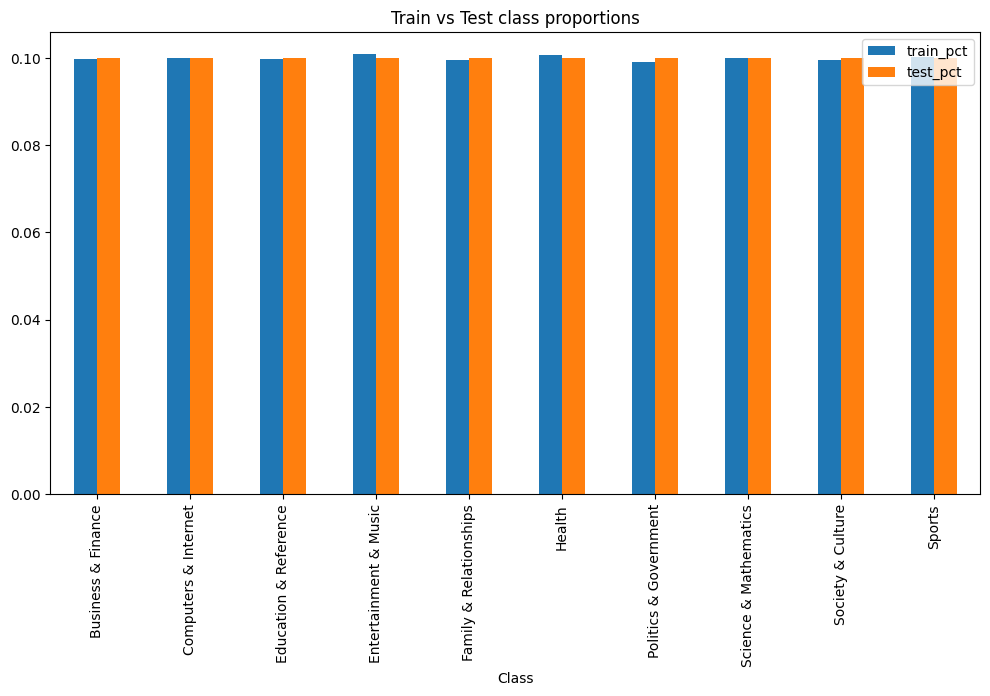

In [15]:
print("Train class counts:")
display(train_df["Class"].value_counts().sort_index())
print("Test class counts:")
display(test_df["Class"].value_counts().sort_index())

# quick normalized bar plot
plt.figure(figsize=(10,6))
train_counts = train_df["Class"].value_counts(normalize=True).sort_index()
test_counts  = test_df["Class"].value_counts(normalize=True).sort_index()
comp = pd.concat([train_counts, test_counts], axis=1, keys=["train_pct","test_pct"]).fillna(0)
comp.plot.bar(figsize=(12,6))
plt.title("Train vs Test class proportions")
plt.show()


## Component-wise length stats (chars, words, sentences)

In [16]:
def add_length_features(df, col):
    df[f"{col}_char_count"] = df[col].fillna("").astype(str).apply(len)
    df[f"{col}_word_count"] = df[col].fillna("").astype(str).apply(lambda x: len(x.split()))
    df[f"{col}_sent_count"] = df[col].fillna("").astype(str).apply(lambda x: len(nltk.sent_tokenize(x)))

updated_train_df = train_df.copy()
for col in ["question_title","question_content","best_answer","full_text"]:
    add_length_features(updated_train_df, col)

updated_train_df[["question_title_word_count","question_content_word_count","best_answer_word_count","full_text_word_count"]].describe().T


,count,mean,std,min,25%,50%,75%,max
question_title_word_count,280003.0,10.729028,5.326170,1.0,7.0,10.0,14.0,39.0
question_content_word_count,280003.0,21.615940,37.714632,0.0,0.0,5.0,29.0,837.0
best_answer_word_count,280003.0,58.994982,85.527328,0.0,12.0,31.0,71.0,1169.0
full_text_word_count,280003.0,91.339950,98.239520,1.0,31.0,60.0,114.0,1334.0


In [17]:
updated_train_df.head()

,QA Text,Class,question_title,question_content,best_answer,full_text,question_title_char_count,question_title_word_count,question_title_sent_count,question_content_char_count,question_content_word_count,question_content_sent_count,best_answer_char_count,best_answer_word_count,best_answer_sent_count,full_text_char_count,full_text_word_count,full_text_sent_count
0,Question Title:\ni am good at web design amate...,Business & Finance,i am good at web design amateurly. how can i e...,web design,Hey! Re. Job. I tried to e-mail you using the...,i am good at web design amateurly. how can i e...,74,16,2,10,2,1,319,57,6,405,75,8
1,Question Title:\nMy daughter wants to be a Med...,Education & Reference,My daughter wants to be a Medical Illustrator....,What do they do for sure. I would like to be ...,Medical Illustrator\nMedical Illustrator. Medi...,My daughter wants to be a Medical Illustrator....,78,14,2,122,25,2,1652,164,4,1854,203,8
2,Question Title:\nIs brother Jesus our brother ...,Society & Culture,Is brother Jesus our brother or our King?,,"the all being one, i'd say he's our brother. y...",Is brother Jesus our brother or our King? the...,41,8,1,0,0,0,71,14,2,114,22,3
3,Question Title:\nwhat is I-20?\nQuestion Conte...,Education & Reference,what is I-20?,students need I 20 for being admitted in Unive...,an I 20 is a form that the university will giv...,what is I-20? students need I 20 for being adm...,13,3,1,94,19,1,203,40,3,312,62,5
4,Question Title:\nwhat is a data disk?\nQuestio...,Computers & Internet,what is a data disk?,I heard that it is possible to save files on a...,"i think it's a usb flashdrive. a small, light...",what is a data disk? I heard that it is possib...,20,5,1,210,44,4,217,43,3,449,92,8


## Visualize Length Distributions (word counts) component-wise

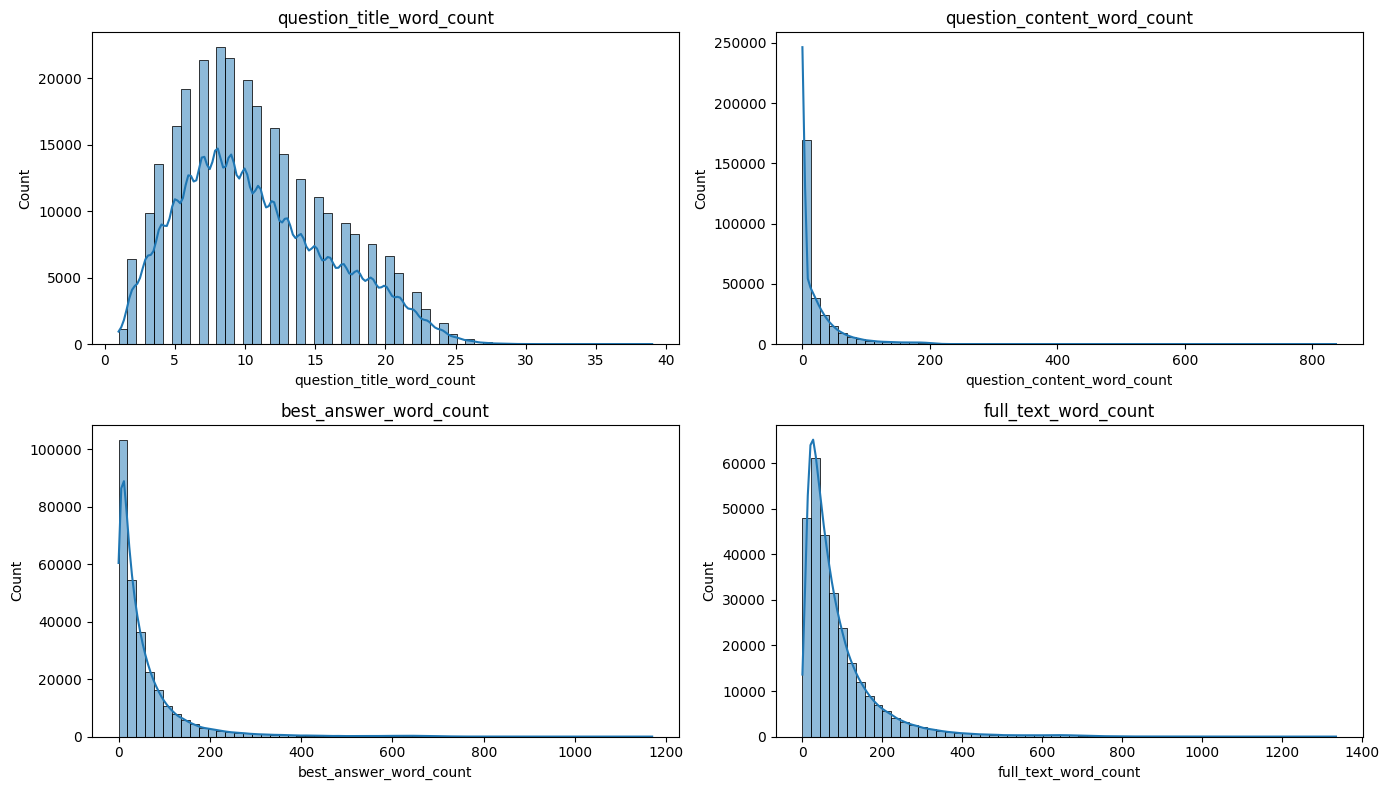

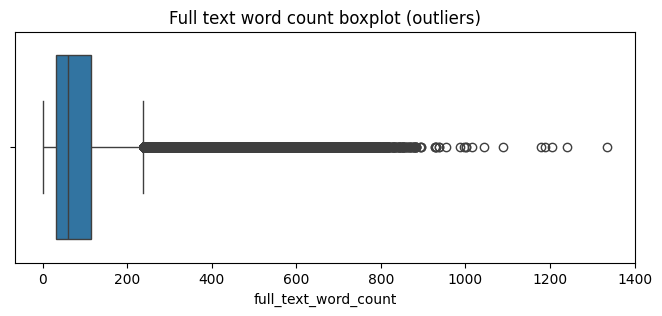

In [18]:
plt.figure(figsize=(14,8))
cols = ["question_title_word_count","question_content_word_count","best_answer_word_count","full_text_word_count"]
for i, c in enumerate(cols,1):
    plt.subplot(2,2,i)
    sns.histplot(updated_train_df[c], bins=60, kde=True)
    plt.title(c)
plt.tight_layout()
plt.show()

# Boxplot to show outliers for full_text
plt.figure(figsize=(8,3))
sns.boxplot(x=updated_train_df["full_text_word_count"])
plt.title("Full text word count boxplot (outliers)")
plt.show()


## Lexical Diversity

In [19]:
def lexical_diversity(text):
  t = str(text).split()
  if len(t) == 0:
      return 0.0
  return len(set(t))/len(t)


for col in ["question_title","question_content","best_answer","full_text"]:
    updated_train_df[f"{col}_lexical_diversity"] = updated_train_df[col].astype(str).apply(lexical_diversity)

updated_train_df[[c for c in updated_train_df.columns if "lexical_diversity" in c]].describe().T


,count,mean,std,min,25%,50%,75%,max
question_title_lexical_diversity,280003.0,0.970065,0.055042,0.142857,0.944444,1.000000,1.000000,1.0
question_content_lexical_diversity,280003.0,0.481104,0.445576,0.000000,0.000000,0.705426,0.911111,1.0
best_answer_lexical_diversity,280003.0,0.842478,0.172387,0.000000,0.759036,0.873239,1.000000,1.0
full_text_lexical_diversity,280003.0,0.798107,0.125245,0.014778,0.707865,0.800000,0.894737,1.0


## Detect URLs, emails, and HTML tags presence as features (Preprocess p2)

In [20]:
def detect_features(text):
  url_re = re.compile(r"http[s]?://|www\.")
  email_re = re.compile(r"\S+@\S+\.\S+")
  html_re = re.compile(r"<[^>]+>")
  t = str(text)

  return {
      "has_url": bool(url_re.search(t)),
      "has_email": bool(email_re.search(t)),
      "has_html": bool(html_re.search(t)),
      "num_qmarks": t.count("?"),
      "num_exclaims": t.count("!"),
  }


feat_df = updated_train_df["QA Text"].apply(lambda x: pd.Series(detect_features(x)))
updated_train_df = pd.concat([updated_train_df, feat_df], axis=1)
updated_train_df[["has_url","has_email","has_html","num_qmarks","num_exclaims"]].sum()


,0
has_url,25850
has_email,2217
has_html,960
num_qmarks,533113
num_exclaims,208104


In [21]:
updated_train_df.head()

,QA Text,Class,question_title,question_content,best_answer,full_text,question_title_char_count,question_title_word_count,question_title_sent_count,question_content_char_count,...,full_text_sent_count,question_title_lexical_diversity,question_content_lexical_diversity,best_answer_lexical_diversity,full_text_lexical_diversity,has_url,has_email,has_html,num_qmarks,num_exclaims
0,Question Title:\ni am good at web design amate...,Business & Finance,i am good at web design amateurly. how can i e...,web design,Hey! Re. Job. I tried to e-mail you using the...,i am good at web design amateurly. how can i e...,74,16,2,10,...,8,0.9375,1.000000,0.754386,0.773333,False,True,False,1,1
1,Question Title:\nMy daughter wants to be a Med...,Education & Reference,My daughter wants to be a Medical Illustrator....,What do they do for sure. I would like to be ...,Medical Illustrator\nMedical Illustrator. Medi...,My daughter wants to be a Medical Illustrator....,78,14,2,122,...,8,1.0000,0.920000,0.640244,0.660099,True,False,True,3,0
2,Question Title:\nIs brother Jesus our brother ...,Society & Culture,Is brother Jesus our brother or our King?,,"the all being one, i'd say he's our brother. y...",Is brother Jesus our brother or our King? the...,41,8,1,0,...,3,0.7500,0.000000,1.000000,0.863636,False,False,False,1,0
3,Question Title:\nwhat is I-20?\nQuestion Conte...,Education & Reference,what is I-20?,students need I 20 for being admitted in Unive...,an I 20 is a form that the university will giv...,what is I-20? students need I 20 for being adm...,13,3,1,94,...,5,1.0000,0.842105,0.800000,0.677419,False,False,False,2,0
4,Question Title:\nwhat is a data disk?\nQuestio...,Computers & Internet,what is a data disk?,I heard that it is possible to save files on a...,"i think it's a usb flashdrive. a small, light...",what is a data disk? I heard that it is possib...,20,5,1,210,...,8,1.0000,0.818182,0.837209,0.717391,False,False,False,2,0


## Top tokens overall & helper functions (uses simple cleaning)


In [22]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=20, ng_range=(1,1), stopwords=None):
    vect = CountVectorizer(ngram_range=ng_range, stop_words=stopwords, min_df=1)
    X = vect.fit_transform(corpus.astype(str))
    sums = np.array(X.sum(axis=0)).flatten()
    terms = np.array(vect.get_feature_names_out())
    top_idxs = sums.argsort()[::-1][:n]
    return list(zip(terms[top_idxs], sums[top_idxs]))


print("Top words in full_text (raw):")
print(get_top_n_words(updated_train_df["full_text"], n=30, ng_range=(1,1), stopwords=stop_words)[:30])


Top words in full_text (raw):
[('like', np.int64(89810)), ('get', np.int64(87187)), ('would', np.int64(81658)), ('one', np.int64(79648)), ('know', np.int64(76279)), ('people', np.int64(60555)), ('think', np.int64(60192)), ('want', np.int64(52886)), ('good', np.int64(52466)), ('go', np.int64(50864)), ('time', np.int64(50694)), ('need', np.int64(46094)), ('help', np.int64(44103)), ('make', np.int64(41703)), ('com', np.int64(41152)), ('also', np.int64(40103)), ('really', np.int64(38134)), ('way', np.int64(35931)), ('find', np.int64(35765)), ('see', np.int64(33264)), ('could', np.int64(32814)), ('www', np.int64(32075)), ('many', np.int64(31151)), ('best', np.int64(31034)), ('much', np.int64(30559)), ('work', np.int64(29608)), ('use', np.int64(29548)), ('first', np.int64(29334)), ('take', np.int64(28697)), ('love', np.int64(28497))]


## Top words per class (show top 10 for each class)


In [23]:
def top_per_class(df, text_col="full_text", label_col="Class", top_n=10, ng=(1,1)):
    classes = df[label_col].unique()
    result = {}
    for cl in sorted(classes):
        subset = df[df[label_col]==cl]
        top = get_top_n_words(subset[text_col], n=top_n, ng_range=ng, stopwords=stop_words)
        result[cl] = top
    return result


top1 = top_per_class(updated_train_df, text_col="question_title", top_n=10, ng=(1,1))
for cl, toks in top1.items():
    print(f"\n=== {cl} ===")
    print(toks)



=== Business & Finance ===
[('get', np.int64(2158)), ('find', np.int64(1639)), ('know', np.int64(1233)), ('anyone', np.int64(1143)), ('need', np.int64(1140)), ('job', np.int64(1127)), ('would', np.int64(1000)), ('business', np.int64(999)), ('money', np.int64(969)), ('best', np.int64(968))]

=== Computers & Internet ===
[('computer', np.int64(2742)), ('get', np.int64(2468)), ('yahoo', np.int64(2114)), ('help', np.int64(1540)), ('free', np.int64(1406)), ('internet', np.int64(1317)), ('know', np.int64(1255)), ('find', np.int64(1191)), ('windows', np.int64(1188)), ('anyone', np.int64(1060))]

=== Education & Reference ===
[('help', np.int64(1780)), ('school', np.int64(1502)), ('get', np.int64(1316)), ('need', np.int64(1261)), ('know', np.int64(1187)), ('find', np.int64(1102)), ('anyone', np.int64(999)), ('good', np.int64(932)), ('please', np.int64(903)), ('college', np.int64(859))]

=== Entertainment & Music ===
[('song', np.int64(2969)), ('anyone', np.int64(2008)), ('know', np.int64(1706

## Top bigrams/trigrams for a specific class example

In [24]:
example_class = updated_train_df["Class"].dropna().unique()[0]  # pick first class as example
print("Example class:", example_class)
print("Top bigrams:", get_top_n_words(updated_train_df[train_df["Class"]==example_class]["full_text"], n=20, ng_range=(2,2), stopwords=stop_words))
print("Top trigrams:", get_top_n_words(updated_train_df[train_df["Class"]==example_class]["full_text"], n=20, ng_range=(3,3), stopwords=stop_words))


Example class: Business & Finance
Top bigrams: [('http www', np.int64(2096)), ('nhttp www', np.int64(2070)), ('would like', np.int64(898)), ('credit card', np.int64(872)), ('real estate', np.int64(841)), ('good luck', np.int64(766)), ('yahoo com', np.int64(676)), ('ngood luck', np.int64(675)), ('make sure', np.int64(608)), ('anyone know', np.int64(545)), ('make money', np.int64(494)), ('best way', np.int64(473)), ('small business', np.int64(445)), ('com nhttp', np.int64(405)), ('want know', np.int64(392)), ('web site', np.int64(392)), ('credit report', np.int64(363)), ('get job', np.int64(335)), ('need know', np.int64(324)), ('please help', np.int64(324))]
Top trigrams: [('com nhttp www', np.int64(340)), ('www powerhomebiz com', np.int64(224)), ('http www powerhomebiz', np.int64(177)), ('www sba gov', np.int64(171)), ('would like know', np.int64(166)), ('wikipedia org wiki', np.int64(149)), ('en wikipedia org', np.int64(148)), ('http www sba', np.int64(133)), ('answers yahoo com', np.i

## Wordcloud per-class


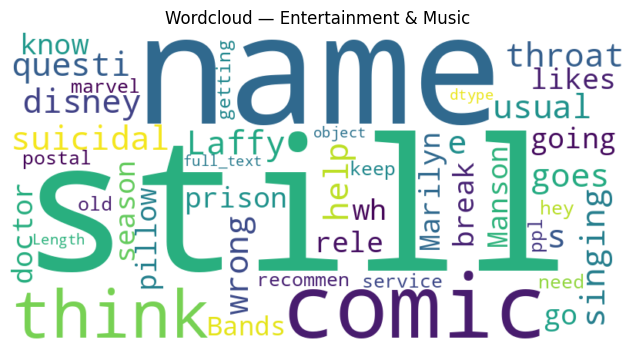

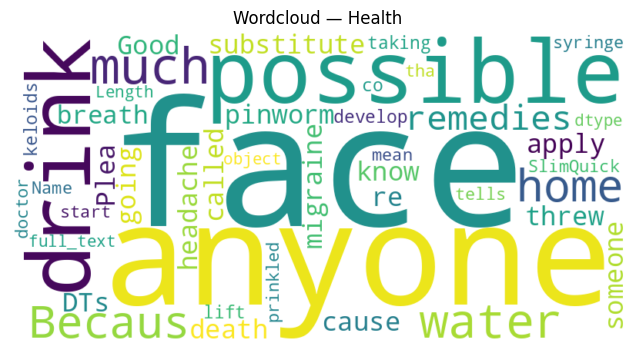

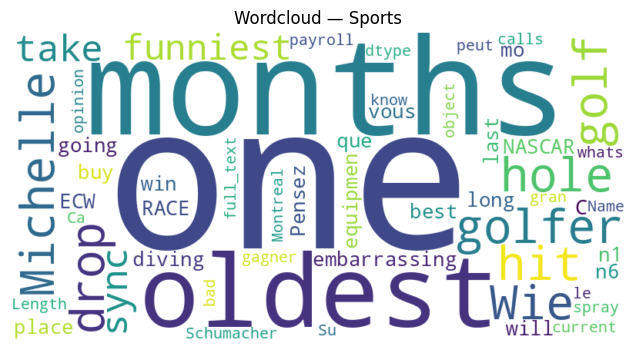

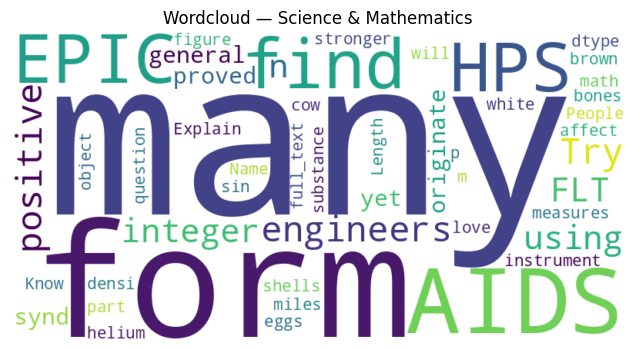

In [25]:
def plot_wordcloud(text, title=None, max_words=150):
    wc = WordCloud(width=800, height=400, background_color="white", max_words=max_words)
    wc.generate(" ".join(str(text).split()))
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


# Example: plot wordcloud for top 4 most common classes
top_classes = updated_train_df["Class"].value_counts().head(4).index.tolist()
for cl in top_classes:
    plot_wordcloud(updated_train_df[updated_train_df["Class"]==cl]["full_text"].astype(str), title=f"Wordcloud — {cl}")


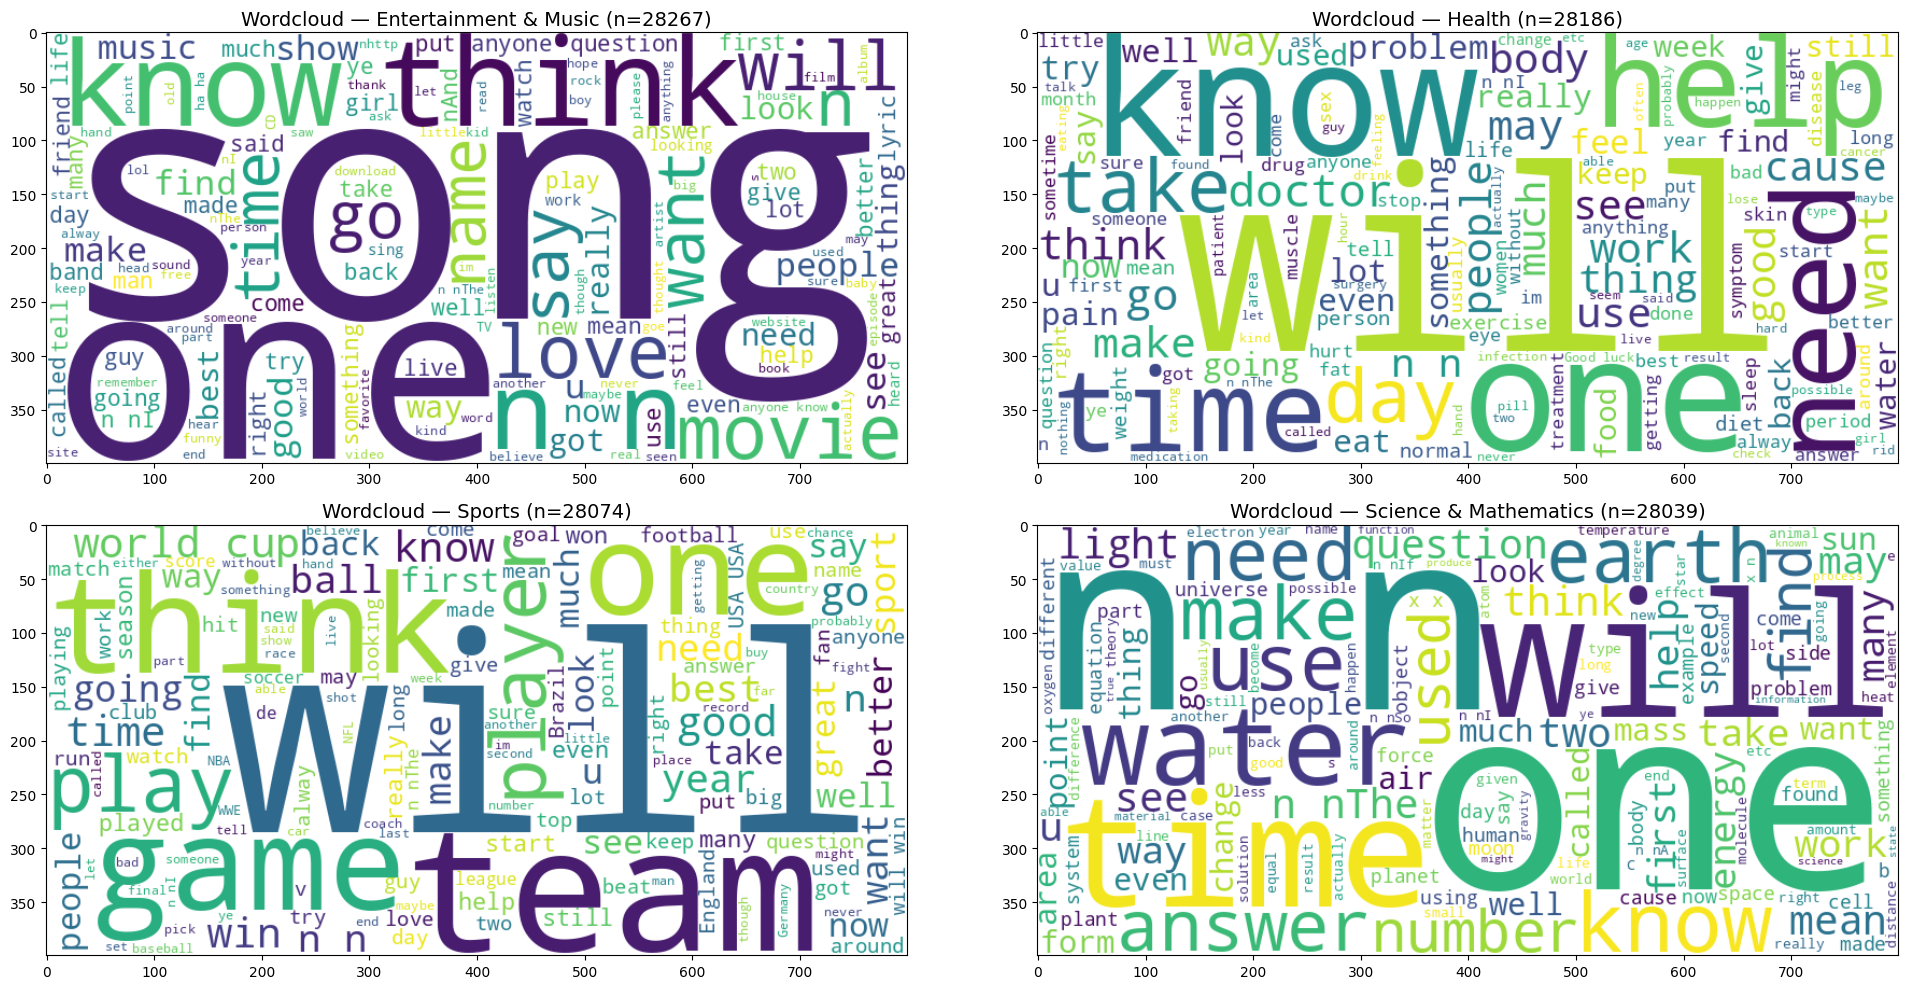

In [29]:
def plot_wordclouds_in_grid(df, classes_to_plot, rows=2, cols=2, max_words=150):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.flatten()  # Flatten the 2x2 array of axes for easy iteration

    wc = WordCloud(width=800, height=400, background_color="white", max_words=max_words, random_state=42)

    # Loop through the classes and plot each word cloud in its own subplot
    for i, cl in enumerate(classes_to_plot):
        if i >= len(axes):
            break # Stop if we run out of subplots

        text_data = df[df["Class"] == cl]["full_text"].astype(str)
        text_string = " ".join(text_data.values)

        wc.generate(text_string)

        # Plot on the current subplot
        axes[i].imshow(wc, interpolation="bilinear")
        count = len(text_data)
        axes[i].set_title(f"Wordcloud — {cl} (n={count})", fontsize=14)

    # If there are empty subplots, hide them
    for i in range(len(classes_to_plot), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


top_classes = updated_train_df["Class"].value_counts().head(4).index.tolist()
plot_wordclouds_in_grid(updated_train_df, top_classes, rows=2, cols=2)

In [27]:
# Todos:
# verify both the wordcloud implementations.

## Outliers: shortest & longest examples per component


In [31]:
for col in ["question_title","question_content","best_answer","full_text"]:
    wc = f"{col}_word_count"
    idx_min = updated_train_df[wc].idxmin()
    idx_max = updated_train_df[wc].idxmax()
    print(f"\n== {col} ==")
    print("Shortest (len={}):\n".format(updated_train_df.loc[idx_min, wc]), updated_train_df.loc[idx_min, col])
    print("\nLongest (len={}):\n".format(updated_train_df.loc[idx_max, wc]), updated_train_df.loc[idx_max, col][:1000], "...\n")



== question_title ==
Shortest (len=1):
 white&nerdy?

Longest (len=39):
 d d d d does  c c c c coffee  g g g g g g give  y y y y you  t t t t t the  j j j j jitters  t t t t t too? ...


== question_content ==
Shortest (len=0):
 

Longest (len=837):
 I warn you now this LONG. So long in fact I had to type it up in word and cut and paste so that I didn’t have to keep going back and adding details. I know this is probably against the rules, but I’m sorry, really sorry…Hope you can suffer though this and read it, I really need the help. Thanks in advance.\nLast year I was working at Hobby Lobby. Well while on the job I hurt my back. I kept telling the boss and the assistant manager that my back hurt and I needed to go home. They kept telling me that I would be ok and that I needed to stay until closing time. Well I somehow made it through the day. Well that night I couldn’t sleep. I couldn’t stand and I couldn’t set for more than a minute or two at a time. It was horrible. Well come morn

## Save parsed CSV and summary stats

In [32]:
OUT_DIR = "eda_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
train_df.to_csv(os.path.join(OUT_DIR, "train_parsed.csv"), index=False)
updated_train_df.to_csv(os.path.join(OUT_DIR, "uptaded_train_parsed.csv"), index=False)
print("Saved parsed train to", os.path.join(OUT_DIR, "train_parsed.csv"))
print("Saved parsed train to", os.path.join(OUT_DIR, "uptaded_train_parsed.csv"))

# Save a simple stats CSV for quick reference
stats = {}
stats["n_samples"] = len(train_df)
stats["n_classes"] = train_df["Class"].nunique()
stats["class_counts"] = train_df["Class"].value_counts().to_dict()
pd.DataFrame.from_dict(stats, orient="index").to_csv(os.path.join(OUT_DIR, "train_basic_stats.csv"))
print("Saved basic stats to", os.path.join(OUT_DIR, "train_basic_stats.csv"))


Saved parsed train to eda_outputs/train_parsed.csv
Saved parsed train to eda_outputs/uptaded_train_parsed.csv
Saved basic stats to eda_outputs/train_basic_stats.csv


In [33]:
train_df.head()

,QA Text,Class,question_title,question_content,best_answer,full_text
0,Question Title:\ni am good at web design amate...,Business & Finance,i am good at web design amateurly. how can i e...,web design,Hey! Re. Job. I tried to e-mail you using the...,i am good at web design amateurly. how can i e...
1,Question Title:\nMy daughter wants to be a Med...,Education & Reference,My daughter wants to be a Medical Illustrator....,What do they do for sure. I would like to be ...,Medical Illustrator\nMedical Illustrator. Medi...,My daughter wants to be a Medical Illustrator....
2,Question Title:\nIs brother Jesus our brother ...,Society & Culture,Is brother Jesus our brother or our King?,,"the all being one, i'd say he's our brother. y...",Is brother Jesus our brother or our King? the...
3,Question Title:\nwhat is I-20?\nQuestion Conte...,Education & Reference,what is I-20?,students need I 20 for being admitted in Unive...,an I 20 is a form that the university will giv...,what is I-20? students need I 20 for being adm...
4,Question Title:\nwhat is a data disk?\nQuestio...,Computers & Internet,what is a data disk?,I heard that it is possible to save files on a...,"i think it's a usb flashdrive. a small, light...",what is a data disk? I heard that it is possib...


In [34]:
updated_train_df.head()

,QA Text,Class,question_title,question_content,best_answer,full_text,question_title_char_count,question_title_word_count,question_title_sent_count,question_content_char_count,...,full_text_sent_count,question_title_lexical_diversity,question_content_lexical_diversity,best_answer_lexical_diversity,full_text_lexical_diversity,has_url,has_email,has_html,num_qmarks,num_exclaims
0,Question Title:\ni am good at web design amate...,Business & Finance,i am good at web design amateurly. how can i e...,web design,Hey! Re. Job. I tried to e-mail you using the...,i am good at web design amateurly. how can i e...,74,16,2,10,...,8,0.9375,1.000000,0.754386,0.773333,False,True,False,1,1
1,Question Title:\nMy daughter wants to be a Med...,Education & Reference,My daughter wants to be a Medical Illustrator....,What do they do for sure. I would like to be ...,Medical Illustrator\nMedical Illustrator. Medi...,My daughter wants to be a Medical Illustrator....,78,14,2,122,...,8,1.0000,0.920000,0.640244,0.660099,True,False,True,3,0
2,Question Title:\nIs brother Jesus our brother ...,Society & Culture,Is brother Jesus our brother or our King?,,"the all being one, i'd say he's our brother. y...",Is brother Jesus our brother or our King? the...,41,8,1,0,...,3,0.7500,0.000000,1.000000,0.863636,False,False,False,1,0
3,Question Title:\nwhat is I-20?\nQuestion Conte...,Education & Reference,what is I-20?,students need I 20 for being admitted in Unive...,an I 20 is a form that the university will giv...,what is I-20? students need I 20 for being adm...,13,3,1,94,...,5,1.0000,0.842105,0.800000,0.677419,False,False,False,2,0
4,Question Title:\nwhat is a data disk?\nQuestio...,Computers & Internet,what is a data disk?,I heard that it is possible to save files on a...,"i think it's a usb flashdrive. a small, light...",what is a data disk? I heard that it is possib...,20,5,1,210,...,8,1.0000,0.818182,0.837209,0.717391,False,False,False,2,0


#